## Business Objective

To apply supervised machine learning techniques on a dataset from a Hackerrank survey about career choices in Technology to develop a model that can predict from key fields in the survey data whether the respondant is female or male 

Setting up and importing the Hackerrank dataset from Kaggle

In [1]:
import pandas as pd
import numpy as np

In [ ]:
import zipfile
import kaggle

# Kaggle - To use the Kaggle Public API, achieve a token from Kaggle and 
# save the details in a json file in your computer's directory: user /.kaggle/kaggle.json 
# In the Terminal use the pip tool: pip install kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

# Importing the numeric data from Hackerrank Developer Survey 2018 from Kaggle
api.dataset_download_file('hackerrank/developer-survey-2018', file_name='HackerRank-Developer-Survey-2018-Numeric.csv')
with zipfile.ZipFile('HackerRank-Developer-Survey-2018-Numeric.csv.zip', 'r') as zipref:
        zipref.extractall()
raw_data = pd.read_csv('HackerRank-Developer-Survey-2018-Numeric.csv')

In [ ]:
# Only keep useful columns
hack_data = raw_data.iloc[:, [4,5,6,7,9,11,12,13,18,20,21,23,25,26,27,28,29,
                                30,31,32,33,34,35,36,37]].copy()
                            
# Export to csv file so don't need to keep downloading from Kaggle
hack_data.to_csv('raw_hackerrank_data.csv', index = False)

# Cleaning the Hackkerank dataset 

In [2]:
# # Import from csv file, to bypass the above downloading from Kaggle 
hack_data = pd.read_csv('raw_hackerrank_data.csv')

In [3]:
# Looking through the actual data file, it was found that #NULL! has been used instead of Nan throughout
hack_data.replace({'#NULL!': np.nan}, inplace=True)

# List all the likely candidates for NaN values, ie the ones with data type 'object'
null_list = list(hack_data.select_dtypes(include=['object']).columns)
for i in null_list:
    print (i, ": number of null values = ", sum(hack_data[i].isnull()))

q1AgeBeginCoding : number of null values =  30
q2Age : number of null values =  41
q3Gender : number of null values =  69
q4Education : number of null values =  305
q5DegreeFocus : number of null values =  162
q9CurrentRole : number of null values =  35
q10Industry : number of null values =  674


### Cleaning target variable data

In [4]:
# Remove all rows that contain null values under q3Gender - they are of no use to this model
hack_data.dropna(subset=['q3Gender'], inplace = True)    # no. of rows falls from 25090 to 25021

#Convert non-binary(3) to female(2), and make female/non-bin = 1, male = 0
hack_data['q3Gender'] = hack_data['q3Gender'].astype(int)
hack_data['q3Gender'] = hack_data['q3Gender'].replace(3,2)
hack_data['q3Gender'] = hack_data['q3Gender'].replace(1,0)
hack_data['q3Gender'] = hack_data['q3Gender'].replace(2,1)

### Cleaning the other variables

In [5]:
# Null values - fill the ones for Age with the median, and then drop all other rows with NaNs
hack_data["q2Age"] = hack_data["q2Age"].astype(float)
age_median = int(hack_data.q2Age.median()) # 3
hack_data['q2Age'].fillna(age_median, inplace=True)

In [6]:
# Drop all null values
for i in null_list:
    hack_data.dropna(subset=[i], inplace = True)

In [7]:
# Keep q5DegreeFocus, q9CurrentRole, q10Industry data types as 'objects' for one hot encoding
# Ensure every other column only contains integers 

integer_list = list(hack_data.columns.values)
categoricals = ["q5DegreeFocus", "q9CurrentRole", "q10Industry"]
for i in categoricals:
    integer_list.remove(i)
for i in integer_list:
    hack_data[i] = hack_data[i].astype(int)

In [8]:
# remove students
hack_data = hack_data[hack_data['q8Student'] == 0]  # 
hack_data.drop(['q8Student'], axis =1, inplace=True)

# q4Education  remove rows with 0 (level of education - other) 
hack_data = hack_data[hack_data['q4Education'] != 0]

# q8JobLevel  remove rows with 0, 11, 1, 3 (Other, None, Student)
hack_data = hack_data[hack_data.q8JobLevel.isin([0,1,11]) == False]

# q8JobLevel  replace Freelancer[3] with the median q8joblevel - (there are 479 Freelancers)
joblevel_median = hack_data.q8JobLevel[hack_data['q8JobLevel'] != 3].median() # median = 5
hack_data['q8JobLevel'] = hack_data['q8JobLevel'].replace(3,joblevel_median)

# q9CurrentRole  remove '0', '18' (Other, Student).  NB These are string values not integer
hack_data = hack_data[hack_data.q9CurrentRole.isin(['0','18']) == False]
# q10Industry   remove 0 (Other)
hack_data = hack_data[hack_data['q10Industry'] != 0]

# Now there are 13004 entries

In [9]:
print('Percentage of our cleaned data that represents female/non-bi = ',hack_data['q3Gender'].mean() * 100)   
# 13.1% female/non bi

Percentage of our cleaned data that represents female/non-bi =  13.149800061519532


In [55]:
# Saving (or retrieving) cleaned data

# Saving
# hack_data.to_csv('clean_hackerrank_data_1.csv', index = True)

# # Retrieving - 3 columns are returned as integers, and need to be classed as objects:
hack_data = pd.read_csv('clean_hackerrank_data_1.csv', index_col=0)
for i in ["q5DegreeFocus", "q9CurrentRole", "q10Industry"]:
    hack_data[i] = hack_data[i].astype(object)

## Use of machine learning to predict factors that attract - deter women from careers in Technology

In [11]:
import pickle
import os
from IPython.display import Math
from itertools import product

#### machine learning and stats libraries
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (auc, confusion_matrix, roc_curve, average_precision_score, 
                             accuracy_score, precision_score, precision_recall_curve,
                             recall_score)

##### visualisation libraries
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 12
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [12]:
# One-hot encode categorical variables  
one_hot_df = pd.get_dummies(hack_data, drop_first=True)
one_hot_df.columns.values

array(['q1AgeBeginCoding', 'q2Age', 'q3Gender', 'q4Education',
       'q6LearnCodeUni', 'q6LearnCodeSelfTaught', 'q6LearnCodeAccelTrain',
       'q8JobLevel', 'q12JobCritPrefTechStack', 'q12JobCritCompMission',
       'q12JobCritCompCulture', 'q12JobCritWorkLifeBal',
       'q12JobCritCompensation', 'q12JobCritProximity', 'q12JobCritPerks',
       'q12JobCritSmartPeopleTeam', 'q12JobCritImpactwithProduct',
       'q12JobCritInterestProblems', 'q12JobCritFundingandValuation',
       'q12JobCritStability', 'q12JobCritProfGrowth', 'q5DegreeFocus_1',
       'q5DegreeFocus_2', 'q9CurrentRole_10', 'q9CurrentRole_11',
       'q9CurrentRole_12', 'q9CurrentRole_13', 'q9CurrentRole_14',
       'q9CurrentRole_15', 'q9CurrentRole_16', 'q9CurrentRole_17',
       'q9CurrentRole_19', 'q9CurrentRole_2', 'q9CurrentRole_3',
       'q9CurrentRole_4', 'q9CurrentRole_5', 'q9CurrentRole_6',
       'q9CurrentRole_7', 'q9CurrentRole_8', 'q9CurrentRole_9',
       'q10Industry_1', 'q10Industry_10', 'q10Industry

In [13]:
# check how evenly balanced our dataset is between 1 = female, 0 = male
from locale import normalize
one_hot_df['q3Gender'].value_counts(normalize=True)
# 0.87 for 0 and 0.13 for 1.  In other words, 
# 87% of the dataset are male, 13% female and non-binary

0    0.868502
1    0.131498
Name: q3Gender, dtype: float64

In [14]:
# make the binary value for q3Gender the target variable, and define the train, test data
target = one_hot_df['q3Gender']
one_hot_df_indep = one_hot_df.drop('q3Gender', axis=1)
X = one_hot_df_indep.values
X_train, X_test, y_train, y_test  = train_test_split(X, target, test_size = 0.2, random_state=11) 

## Create a function 
to apply the 3 machine learning algorithms, Decision Tree, Random Forest, Logistic Regression:

- Arguments will be: X_train, X_test, y_train, y_test
- Returns: clf_dt, clf_rf, clf_logit, pred_clf_dt, pred_clf_rf, pred_clf_logit

## Select an Appropriate Performance Metric 

### Class Imbalance  
The data is imbalanced with our target (women working in technology today) only 13% whereas men are 87%.  Therefore thr Accuracy measure is not suitable. Accuracy score is calculated for the set of predicted labels against the true labels.  For this data, we want to focus on the positive results for the gender being female.  The false positives are fine, but we want to limit false negatives.  Therefore Recall is of greater significance than Precision.

<br> Recall - True Positives / True Positives + False Negatives.

<br> Precision - the ratio of false positives / true positives + true negative.

<br> PRC AUC - The area under the curve of a precision-recall plot.  the closer to 1 the better.  This is a good way to measure performance of the model when concerned with the positive outcomes of a minority class.  

<br> ROC/AUC - AUC finds the area under the ROC curve.  The closer to 1 the better.  0.5-0.7 is acceptable, >0.7 is good.  ROC curves used for imbalanced datasets

<br> f1 - Represents both Precision and Recall using the harmonic mean

In [23]:
# def machine_learning(X_train, X_test, y_train, y_test):
#     # Decision tree 
#     clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_split=20, 
#                                 min_samples_leaf=10, max_features=None)
#     clf_dt.fit(X_train, y_train)
#     pred_clf_dt = clf_dt.predict(X_test)
#     proba_clf_dt = clf_dt.predict_proba(X_test)[:, 1]
    
#     # Random forest 
#     clf_rf = RandomForestClassifier(n_estimators=50, max_depth=5, 
#                                     min_samples_leaf=30, max_features=4)
#     clf_rf.fit(X_train, y_train)
#     pred_clf_rf = clf_rf.predict(X_test)
#     proba_clf_rf = clf_rf.predict_proba(X_test)[:, 1]

#     # Logistic regression
#     clf_logit = LogisticRegression(penalty='l2', tol=0.0001, C=1.0)
#     clf_logit.fit(X_train, y_train)
#     pred_clf_logit = clf_logit.predict(X_test)
#     proba_clf_logit = clf_logit.predict_proba(X_test)[:, 1]
    
    

#     precision, recall, thresholds = precision_recall_curve(y_test, proba_clf_dt)
#     plt.plot(recall, precision)
#     plt.ylabel('Precision')
#     plt.xlabel('Recall')
#     plt.show()
#     print("Decision Tree Precision Recall AUC: ", auc(recall, precision))
#     print("Average Precision: ", average_precision_score(y_test, proba_clf_dt))
#     print("ROC AUC", metrics.roc_auc_score(y_test, proba_clf_dt))
#     print("f1 score for Decision Tree:",metrics.f1_score(y_test, pred_clf_dt))
    

#     precision, recall, thresholds = precision_recall_curve(y_test, proba_clf_rf)
#     plt.plot(recall, precision)
#     plt.show()
#     print("Random Forest Precision Recall AUC: ", auc(recall, precision))
#     print("Average Precision: ", average_precision_score(y_test, proba_clf_rf))
#     print("ROC AUC", metrics.roc_auc_score(y_test, proba_clf_rf))
#     print("f1 score for Random Forest:",metrics.f1_score(y_test, pred_clf_rf))

#     precision, recall, thresholds = precision_recall_curve(y_test, proba_clf_logit)
#     plt.plot(recall, precision)
#     plt.show()
#     print("Logistic Regression Precision Recall AUC: ", auc(recall, precision))
#     print("Average Precision: ", average_precision_score(y_test, proba_clf_logit))
#     print("ROC AUC", metrics.roc_auc_score(y_test, proba_clf_logit))
#     print("f1 score for Logistic Regression:",metrics.f1_score(y_test, pred_clf_logit))

#     return (clf_dt, clf_rf, clf_logit, pred_clf_dt, pred_clf_rf, pred_clf_logit)

In [48]:
def machine_learning(X_train, X_test, y_train, y_test):
    # Decision tree 
    clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_split=20, 
                                min_samples_leaf=10, max_features=None)
    clf_dt.fit(X_train, y_train)
    pred_clf_dt = clf_dt.predict(X_test)
    proba_clf_dt = clf_dt.predict_proba(X_test)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y_test, proba_clf_dt)
    print("Decision Tree Precision Recall AUC: ", auc(recall, precision))
    print("Average Precision: ", average_precision_score(y_test, proba_clf_dt))
    print("ROC AUC", metrics.roc_auc_score(y_test, proba_clf_dt))
    print("f1 score for Decision Tree:",metrics.f1_score(y_test, pred_clf_dt),"\n")


    # Random forest 
    clf_rf = RandomForestClassifier(n_estimators=50, max_depth=5, 
                                    min_samples_leaf=30, max_features=4)
    clf_rf.fit(X_train, y_train)
    pred_clf_rf = clf_rf.predict(X_test)
    proba_clf_rf = clf_rf.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, proba_clf_rf)
    print("Random Forest Precision Recall AUC: ", auc(recall, precision))
    print("Average Precision: ", average_precision_score(y_test, proba_clf_rf))
    print("ROC AUC", metrics.roc_auc_score(y_test, proba_clf_rf))
    print("f1 score for Random Forest:",metrics.f1_score(y_test, pred_clf_rf),"\n")


    # Logistic regression
    clf_logit = LogisticRegression(penalty='l2', tol=0.0001, C=1.0)
    clf_logit.fit(X_train, y_train)
    pred_clf_logit = clf_logit.predict(X_test)
    proba_clf_logit = clf_logit.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, proba_clf_logit)
    print("Logistic Regression Precision Recall AUC: ", auc(recall, precision))
    print("Average Precision: ", average_precision_score(y_test, proba_clf_logit))
    print("ROC AUC", metrics.roc_auc_score(y_test, proba_clf_logit))
    print("f1 score for Logistic Regression:",metrics.f1_score(y_test, pred_clf_logit))

    return (clf_dt, clf_rf, clf_logit, pred_clf_dt, pred_clf_rf, pred_clf_logit)

In [49]:
clf_dt, clf_rf, clf_logit, pred_clf_dt, pred_clf_rf, pred_clf_logit = machine_learning(X_train, X_test, y_train, y_test)

Decision Tree Precision Recall AUC:  0.231773094647232
Average Precision:  0.22451913306725813
ROC AUC 0.6784928555085376
f1 score for Decision Tree: 0.0 

Random Forest Precision Recall AUC:  0.27762994971167576
Average Precision:  0.27909516953779606
ROC AUC 0.7072355104986184
f1 score for Random Forest: 0.0 

Logistic Regression Precision Recall AUC:  0.26644639165531075
Average Precision:  0.26906259817598854
ROC AUC 0.6922481701905114
f1 score for Logistic Regression: 0.016666666666666666


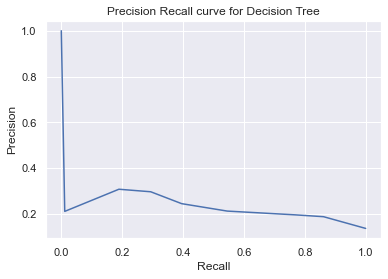

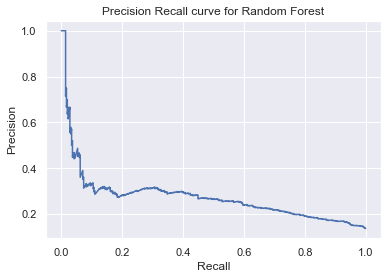

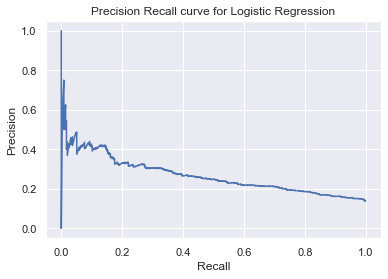

In [27]:
# Plot precision recall curves
# Decision Tree
proba_clf_dt = clf_dt.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, proba_clf_dt)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision Recall curve for Decision Tree")
plt.show()

#Random Forest
proba_clf_rf = clf_rf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, proba_clf_rf)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision Recall curve for Random Forest")
plt.show()

#Logistic Regression
proba_clf_logit = clf_logit.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, proba_clf_logit)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision Recall curve for Logistic Regression")
plt.show()

# Baseline performance of the model

At this point, none of the machine learning models are performing well.  Decision Tree, Randpm Forest and Logistic Regression each have a Precision Recall AUC between 20 and 30%, and an ROC AUC of around 70%.




In [83]:
# generating confusion matrices
print(metrics.confusion_matrix(y_test, pred_clf_dt))
print(metrics.confusion_matrix(y_test, pred_clf_rf))
print(metrics.confusion_matrix(y_test, pred_clf_logit))

[[1131 1116]
 [  85  269]]
[[1449  798]
 [ 128  226]]
[[1435  812]
 [ 129  225]]


## Test if using Under or Over Sampling techniques will improve accuracy
Current split is around 13% female, 87% male

In [28]:
one_hot_df['q3Gender'].value_counts(normalize=True)   
# 0 = 0.864029, 1 = 0.135971

0    0.868502
1    0.131498
Name: q3Gender, dtype: float64

### Different sampling techniques to compare:
Under sampling - Cluster Centroids, Random Under Sampling
Over sampling - Smote, Random Over Sampling
Combination - Smote/Tomek

In [29]:
# pip install -U imbalanced-learn
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek

In [30]:
# one_hot_df_indep is the variable that contains our 
# one hot encoded hack_data without q3Gender 
target = one_hot_df['q3Gender']
one_hot_df_indep = one_hot_df.drop('q3Gender', axis=1)
X = one_hot_df_indep.values
X_train, X_test, y_train, y_test  = train_test_split(X, target, test_size = 0.2, random_state=11) 

In [31]:
# This can take about 20 seconds to run

undersampler1 = ClusterCentroids()
X_train_cluster, y_train_cluster = undersampler1.fit_resample(X_train, y_train)

undersampler2 = RandomUnderSampler(sampling_strategy=1)
X_train_randunder, y_train_randunder = undersampler2.fit_resample(X_train, y_train)

oversample1 = SMOTE(random_state=11)
X_train_smote, y_train_smote = oversample1.fit_resample(X_train, y_train)

oversample2 = RandomOverSampler(random_state=11)
oversample2.fit(X_train, y_train)
X_train_randover, y_train_randover = oversample2.fit_resample(X_train, y_train)

overunder_sampler = SMOTETomek(random_state=11)
X_train_overunder, y_train_overunder = overunder_sampler.fit_resample(X_train, y_train)

In [40]:
y_train_cluster.value_counts(normalize=True)

0    0.5
1    0.5
Name: q3Gender, dtype: float64

In [33]:
print('Cluster Centroids Under Sampling')
clf_dt, clf_rf, clf_logit, pred_clf_dt, pred_clf_rf, pred_clf_logit = machine_learning(X_train_cluster, X_test, y_train_cluster, y_test)
# gives prediction accuracy of:  Decision Tree 24%, Random Forest 24%, Logistic Regression 59%

Cluster Centroids Under Sampling
Decision Tree Precision Recall AUC:  0.30777903690752106
Average Precision:  0.14918692307906203
ROC AUC 0.5355533680814848
f1 score for Decision Tree: 0.24388349514563104 

Random Forest Precision Recall AUC:  0.22520085380582608
Average Precision:  0.22756010091153503
ROC AUC 0.6659664235301809
f1 score for Random Forest: 0.25045905251560774 

Logistic Regression Precision Recall AUC:  0.25592107729990154
Average Precision:  0.2583787015747266
ROC AUC 0.6847667574342691
f1 score for Logistic Regression: 0.30956968529222867


In [34]:
print('Random Under Sampling')
clf_dt, clf_rf, clf_logit, pred_clf_dt, pred_clf_rf, pred_clf_logit = machine_learning(X_train_randunder, X_test, y_train_randunder, y_test)

# gives prediction accuracy of:  Decision Tree 60%, Random Forest 60%, Logistic Regression 63% 

Random Under Sampling
Decision Tree Precision Recall AUC:  0.3059331472614586
Average Precision:  0.22751578575530967
ROC AUC 0.6841576590507369
f1 score for Decision Tree: 0.3175 

Random Forest Precision Recall AUC:  0.2740812563716343
Average Precision:  0.2756834875241119
ROC AUC 0.7038807550054185
f1 score for Random Forest: 0.33222148098732485 

Logistic Regression Precision Recall AUC:  0.2647568460269894
Average Precision:  0.26665486767793983
ROC AUC 0.6900795536547161
f1 score for Logistic Regression: 0.32078103207810327


In [35]:
print('Smote Over Sampling')
clf_dt, clf_rf, clf_logit, pred_clf_dt, pred_clf_rf, pred_clf_logit = machine_learning(X_train_smote, X_test, y_train_smote, y_test)

# gives prediction accuracy of:  Decision Tree 68%, Random Forest 67%, Logistic Regression 73% 

Smote Over Sampling
Decision Tree Precision Recall AUC:  0.3226418929041075
Average Precision:  0.22726009190595672
ROC AUC 0.6707090936062899
f1 score for Decision Tree: 0.32387096774193547 

Random Forest Precision Recall AUC:  0.25255055826609
Average Precision:  0.25432353954659925
ROC AUC 0.6885640364176717
f1 score for Random Forest: 0.33971690258118237 

Logistic Regression Precision Recall AUC:  0.24123038522518758
Average Precision:  0.24372398561593306
ROC AUC 0.6711993895187305
f1 score for Logistic Regression: 0.30660377358490565


In [36]:
print('Random Over Sampling')
clf_dt, clf_rf, clf_logit, pred_clf_dt, pred_clf_rf, pred_clf_logit = machine_learning(X_train_randover, X_test, y_train_randover, y_test)

# gives prediction accuracy of:  Decision Tree 60%, Random Forest 62%, Logistic Regression 64% 

Random Over Sampling
Decision Tree Precision Recall AUC:  0.3009093410286706
Average Precision:  0.22807311444371497
ROC AUC 0.6816307493481579
f1 score for Decision Tree: 0.314385150812065 

Random Forest Precision Recall AUC:  0.2711008046812909
Average Precision:  0.27248000199857314
ROC AUC 0.7028071326740739
f1 score for Random Forest: 0.3321941216678058 

Logistic Regression Precision Recall AUC:  0.26930811286449297
Average Precision:  0.2717049512631472
ROC AUC 0.6913040362668115
f1 score for Logistic Regression: 0.3261494252873563


In [37]:
print('Smote Tomek Over/Under Sampling')
clf_dt, clf_rf, clf_logit, pred_clf_dt, pred_clf_rf, pred_clf_logit = machine_learning(X_train_overunder, X_test, y_train_overunder, y_test)

# gives prediction accuracy of:  Decision Tree 66%, Random Forest 67%, Logistic Regression 73% 


Smote Tomek Over/Under Sampling
Decision Tree Precision Recall AUC:  0.3235347515757276
Average Precision:  0.22889454163451267
ROC AUC 0.6717135716422902
f1 score for Decision Tree: 0.3259259259259259 

Random Forest Precision Recall AUC:  0.261701893745695
Average Precision:  0.2638826891825857
ROC AUC 0.6895678858691688
f1 score for Random Forest: 0.3385892116182573 

Logistic Regression Precision Recall AUC:  0.24195462364879264
Average Precision:  0.2444893507008118
ROC AUC 0.6713364209404127
f1 score for Logistic Regression: 0.3027413587604291


The most promising results achieved from either oversampling, undersampling or random over/under were:

Decision Tree
Random Under Sampling, and Random Over - Precision Recall AUC raised from 23% to 31%, f1 from 0 to 32%, everything else raised by 1%
Smote Over Sampling, and Smote Over/Under - Precision Recall AUC raised from 23% to 32%, f1 from 0 to 32%, everything else unaffected

Random Forest 
Random Under Sampling, and Random Over - Precision Recall AUC raised from 26% to 27%, f1 from 0 to 33%, Average precision raised by 1%

Logistic Regression 
Mostly unchanged
Random Over and Random Under Sampling - Precision Recall AUC unchanged at 27%, f1 from 0 to 33%, everything else unchanged

From these Random Over Sampling and Random Under Sampling feel the most promising.

## Class Weight Optimization

By default class_weight = None  meaning that even weight will automatically given to both classes (female/male)
class_weight = 'balanced' means the model will automatically assign the class weights in inverse proportion to their respective frequencies

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator=  clf_rf, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Random Forest - Scoring for different class weights', fontsize=24)

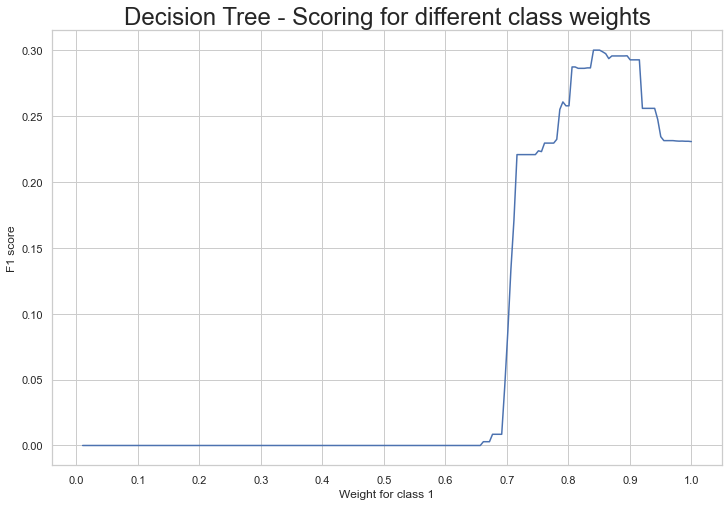

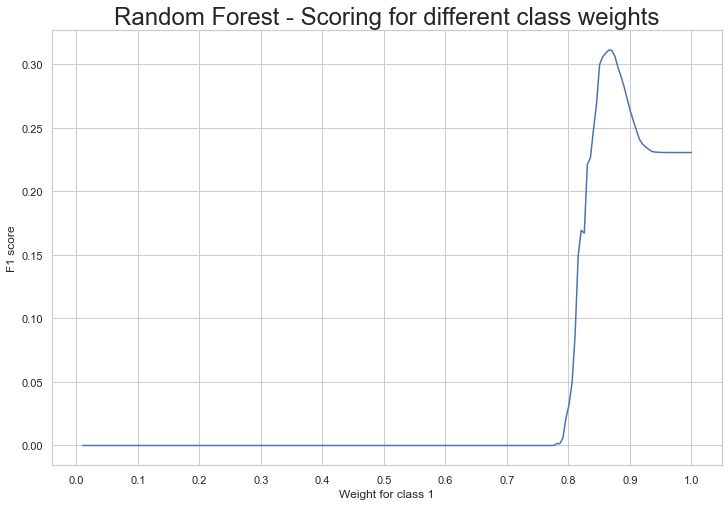

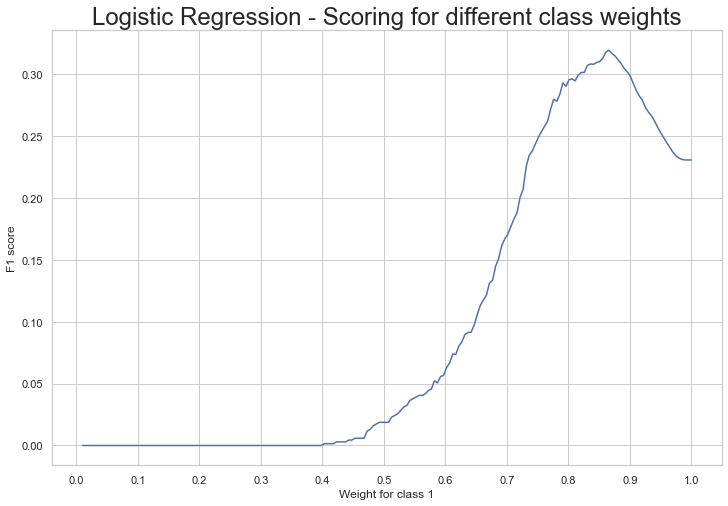

From the above graphs, the optimal class weights for each algorithm appear to be around:
Decision Tree - 0.850 for Class 1 (Female) - f1 score of 30%
Random Forest - 0.865 for Class 1 (Female) - f1 score of 32%
Logistic Regression - 0.865 for Class 1 (Female) - f1 score of 31%


In [59]:
def machine_learning_weighted(X_train, X_test, y_train, y_test):
    # Decision tree 
    clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_split=20, 
                                min_samples_leaf=10, max_features=None, class_weight={0:0.15, 1:0.85})
    clf_dt.fit(X_train, y_train)
    pred_clf_dt = clf_dt.predict(X_test)
    proba_clf_dt = clf_dt.predict_proba(X_test)[:, 1]
    
    precision, recall, thresholds = precision_recall_curve(y_test, proba_clf_dt)
    print("Decision Tree Precision Recall AUC: ", auc(recall, precision))
    print("Average Precision: ", average_precision_score(y_test, proba_clf_dt))
    print("ROC AUC", metrics.roc_auc_score(y_test, proba_clf_dt))
    print("f1 score for Decision Tree:",metrics.f1_score(y_test, pred_clf_dt),"\n")


    # Random forest 
    clf_rf = RandomForestClassifier(n_estimators=50, max_depth=5, 
                                    min_samples_leaf=30, max_features=4, class_weight={0:0.135, 1:0.865})
    clf_rf.fit(X_train, y_train)
    pred_clf_rf = clf_rf.predict(X_test)
    proba_clf_rf = clf_rf.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, proba_clf_rf)
    print("Random Forest Precision Recall AUC: ", auc(recall, precision))
    print("Average Precision: ", average_precision_score(y_test, proba_clf_rf))
    print("ROC AUC", metrics.roc_auc_score(y_test, proba_clf_rf))
    print("f1 score for Random Forest:",metrics.f1_score(y_test, pred_clf_rf),"\n")


    # Logistic regression
    clf_logit = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, class_weight={0:0.135, 1:0.865})
    clf_logit.fit(X_train, y_train)
    pred_clf_logit = clf_logit.predict(X_test)
    proba_clf_logit = clf_logit.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, proba_clf_logit)
    print("Logistic Regression Precision Recall AUC: ", auc(recall, precision))
    print("Average Precision: ", average_precision_score(y_test, proba_clf_logit))
    print("ROC AUC", metrics.roc_auc_score(y_test, proba_clf_logit))
    print("f1 score for Logistic Regression:",metrics.f1_score(y_test, pred_clf_logit))

    return (clf_dt, clf_rf, clf_logit, pred_clf_dt, pred_clf_rf, pred_clf_logit)

In [61]:
# adding the optimal class weights to the model
clf_dt, clf_rf, clf_logit, pred_clf_dt, pred_clf_rf, pred_clf_logit = machine_learning_weighted(X_train, X_test, y_train, y_test)

Decision Tree Precision Recall AUC:  0.2982602344314548
Average Precision:  0.22544279332643738
ROC AUC 0.6733592058714822
f1 score for Decision Tree: 0.3020667726550079 

Random Forest Precision Recall AUC:  0.2637898947571459
Average Precision:  0.26642208751154267
ROC AUC 0.7037028655910329
f1 score for Random Forest: 0.3494837172359015 

Logistic Regression Precision Recall AUC:  0.2668306265876156
Average Precision:  0.2694604534530359
ROC AUC 0.6920507946565289
f1 score for Logistic Regression: 0.3254437869822485


### Feature selection using SelectKBest

Feature selection is used to select a subset of relevant features in constructing the model.  This can reduce training time, improve generalization, and reduce overfitting.  Some features will be redundant or irrelevant.

In [64]:
from sklearn.feature_selection import SelectKBest, f_regression
# for classification - 
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

In [65]:
one_hot_df = pd.get_dummies(hack_data, drop_first=True)
target = one_hot_df['q3Gender']
one_hot_df_indep = one_hot_df.drop('q3Gender', axis=1)

In [84]:
def ml_selectkbest(X_train, X_test, y_train, y_test):
    # Decision tree 
    clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_split=20, 
                                min_samples_leaf=10, max_features=None, class_weight={0:0.15, 1:0.85})
    clf_dt.fit(X_train, y_train)
    pred_clf_dt = clf_dt.predict(X_test)
    proba_clf_dt = clf_dt.predict_proba(X_test)[:, 1]


    # Random forest 
    clf_rf = RandomForestClassifier(n_estimators=50, max_depth=5, 
                                    min_samples_leaf=30, max_features=4, class_weight = {0:0.135, 1:0.865})
    clf_rf.fit(X_train, y_train)
    pred_clf_rf = clf_rf.predict(X_test)
    proba_clf_rf = clf_rf.predict_proba(X_test)[:, 1]

    # Logistic regression
    clf_logit = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, class_weight={0:0.135, 1:0.865})
    clf_logit.fit(X_train, y_train)
    pred_clf_logit = clf_logit.predict(X_test)
    proba_clf_logit = clf_logit.predict_proba(X_test)[:, 1]
    

    precision, recall, thresholds = precision_recall_curve(y_test, proba_clf_dt)
    dt_pr_auc = auc(recall, precision)
    dt_roc_auc = metrics.roc_auc_score(y_test, proba_clf_dt)
    dt_f1 = metrics.f1_score(y_test, pred_clf_dt)

    precision, recall, thresholds = precision_recall_curve(y_test, proba_clf_rf)
    rf_pr_auc = auc(recall, precision)
    rf_roc_auc = metrics.roc_auc_score(y_test, proba_clf_rf)
    dt_rf = metrics.f1_score(y_test, pred_clf_rf)

    precision, recall, thresholds = precision_recall_curve(y_test, proba_clf_logit)
    logit_pr_auc = auc(recall, precision)
    logit_roc_auc = metrics.roc_auc_score(y_test, proba_clf_logit)
    dt_logit = metrics.f1_score(y_test, pred_clf_logit)
    
    return (dt_pr_auc, rf_pr_auc, logit_pr_auc, dt_roc_auc, rf_roc_auc, logit_roc_auc, dt_f1, dt_rf, dt_logit)

In [85]:
def selectkbest_plot(k_limit, one_hot_df_indep, target, sc_function, func_name):
    k_list = []
    model_list_pr = []
    model_list_roc = []
    model_list_f1 = []

    for x in range(5,k_limit,1):
        k_list.append(x)
        select_class =  SelectKBest(k=x, score_func=sc_function)
        select_class.fit(one_hot_df_indep, target)     # one_hot_df_indep already has q3Gender dropped          
        X_new = select_class.transform(one_hot_df_indep)

        new_one_hot_df = one_hot_df_indep.iloc[:,select_class.get_support()]

        X_new = new_one_hot_df.values
        X_train, X_test, y_train, y_test  = train_test_split(X_new, target, test_size = 0.2, random_state=11) 

        k_results = ml_selectkbest(X_train, X_test, y_train, y_test)
        model_list_pr.append([k_results[0], k_results[1], k_results[2]])
        model_list_roc.append([k_results[3], k_results[4], k_results[5]])
        model_list_f1.append([k_results[6], k_results[7], k_results[8]])
        
    plt.plot(k_list, model_list_pr, label = ['decision tree', 'random forest', 'logistic reg'])
    plt.title("PR AUC scores for a range of k values - SelectKBest " + func_name)
    plt.xlabel('k-value')
    plt.ylabel('PR AUC')
    plt.xticks(np.arange(5.0, k_limit, 2.0))
    plt.legend()
    plt.show()

    plt.plot(k_list, model_list_roc, label = ['decision tree', 'random forest', 'logistic reg'])
    plt.title("ROC AUC scores for a range of k values -  SelectKBest " + func_name)
    plt.xlabel('k-value')
    plt.ylabel('ROC AUC')
    plt.xticks(np.arange(5.0, k_limit, 2.0))
    plt.legend()
    plt.show()

    plt.plot(k_list, model_list_f1, label = ['decision tree', 'random forest', 'logistic reg'])
    plt.title("f1 scores for a range of k values - SelectKBest " + func_name)
    plt.xlabel('k-value')
    plt.ylabel('f1')
    plt.xticks(np.arange(5.0, k_limit, 2.0))
    plt.legend()
    plt.show()

    return   

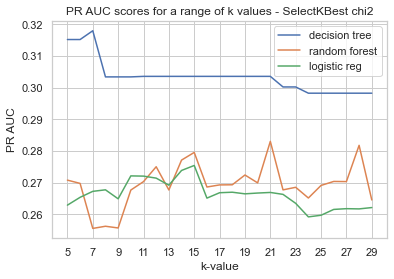

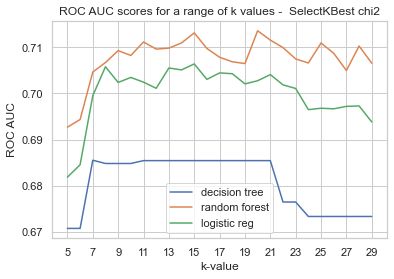

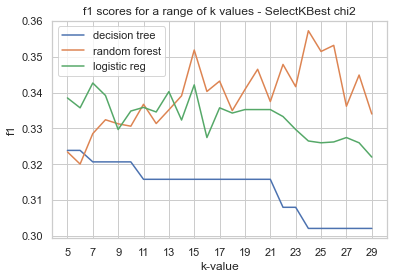

In [86]:
selectkbest_plot(30, one_hot_df_indep, target, chi2, 'chi2')
# Best result k=18, Random Forest >0.28

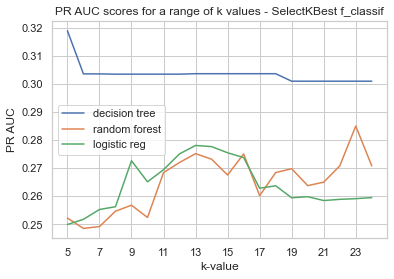

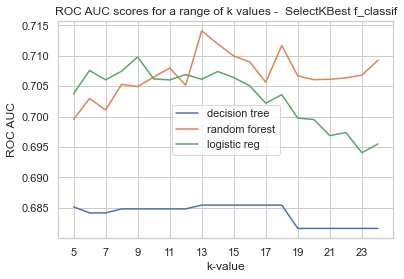

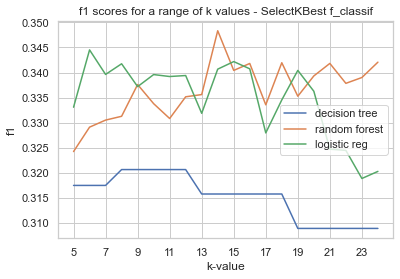

In [87]:
selectkbest_plot(25, one_hot_df_indep, target, f_classif, 'f_classif')
# Best result k=16, Random Forest >0.28

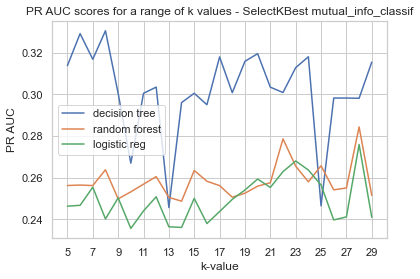

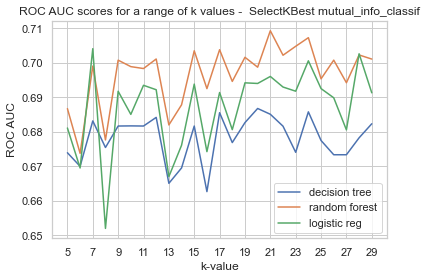

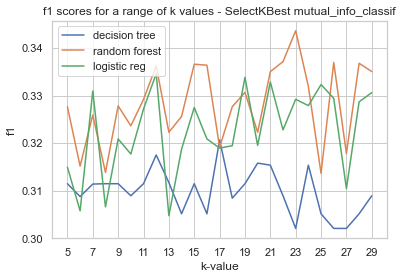

In [88]:
selectkbest_plot(30, one_hot_df_indep, target, mutual_info_classif, 'mutual_info_classif')
# Best result k=54, Random Forest >0.28, Logistic Regression nearly 0.28

Optimal results for SelectKBest (combined with weighted classifier) were found to be:

Decision Tree
<br>k = 24, mutual_info_classic: 32% PR AUC, 69% ROC AUC, 32% f1
<br>k = 5, f_classif: 32% PR AUC, 69% ROC AUC, 32% f1

Random Forest
k = 15, chi2: 28% PR AUC, 71% ROC AUC, 35% f1

Logistic Regression
k = 21, mutual_info_classic: 26% PR AUC, 71% ROC AUC, 33% f1

In [29]:
regressor = DecisionTreeClassifier()
from sklearn.model_selection import validation_curve, cross_validate, ShuffleSplit
from matplotlib import pyplot

In [30]:
cv = ShuffleSplit(n_splits=30, test_size=0.2)
cv_results = cross_validate(regressor, X, target,
                            cv=cv, scoring="roc_auc",
                            return_train_score=True, n_jobs=2)
cv_results = pd.DataFrame(cv_results)

In [31]:
max_depth = [1, 5, 10, 15, 20, 25]
train_scores, test_scores = validation_curve(
    regressor, X, target, param_name="max_depth", param_range=max_depth,
    cv=cv, scoring="average_precision", n_jobs=2)
train_errors, test_errors = -train_scores, -test_scores

Text(0.5, 1.0, 'Validation curve for Decision Tree using average Precision Score values')

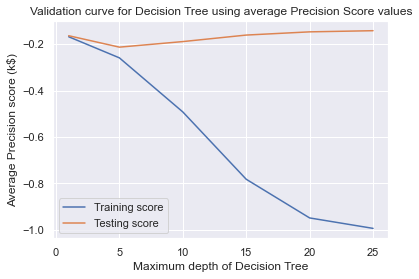

In [33]:
plt.plot(max_depth, train_errors.mean(axis=1), label="Training score")
plt.plot(max_depth, test_errors.mean(axis=1), label="Testing score")
plt.legend()

plt.xlabel("Maximum depth of Decision Tree")
plt.ylabel("Average Precision score (k$)")
plt.title("Validation curve for Decision Tree using average Precision Score values")